In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../datasets/np_train_skills_no_commas.csv')
df = df.dropna()
df.describe()

,Unnamed: 0,Target
count,13004.000000,13004.000000
mean,7745.054137,0.304445
std,5451.320764,0.460190
min,0.000000,0.000000
25%,3451.750000,0.000000
50%,6957.500000,0.000000
75%,10488.250000,1.000000
max,19768.000000,1.000000


In [4]:
df.head()

,Unnamed: 0,Phrase,Target
0,0,significant scope impact,0.0
1,1,monitor compliance,0.0
2,2,self-service reporting solutions,0.0
3,3,experience,0.0
4,4,strong attention detail commitment,1.0


In [5]:
# Get unique words

from collections import Counter

#count unique words
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

text = df['Phrase']
counter = counter_word(text)
num_words = len(counter)
max_len = 20

In [6]:
# train test splits

def split_train_test(features, target, size):
    #size is the size of the training set
    train_size = int(features.shape[0]* size) #check me
    X_train = features[:train_size]
    y_train = target[:train_size]

    X_test = features[train_size:]
    y_test = target[train_size:]
    return X_train, y_train, X_test, y_test

train = df[['Phrase','Target']]
features = train['Phrase']
target = train['Target']
X_train, y_train, X_test, y_test = split_train_test(features, target, 0.8)

#### Preparation for Modelling

In [7]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

2024-01-06 11:13:07.599430: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(X_train)

In [9]:
from keras.preprocessing.sequence import pad_sequences

train_padded = pad_sequences(
    train_sequences, maxlen=max_len, padding="post", truncating="post"
)

In [10]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(
    test_sequences, maxlen=max_len, padding="post", truncating="post"
)

In [11]:
#check inverse
reverse_word_index = dict([(value,key) for (key,value) in word_index.items()])
def decode(text):
    return " ".join([reverse_word_index.get(i, "?") for i in text])
print(decode(train_sequences[0]))
print(df['Phrase'][0])

significant scope impact
significant scope impact


# Modelling

- Model 1: Without GLoVe Embeddings

In [12]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.initializers import Constant

model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Embedding(num_words, 32, input_length=max_len),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [13]:
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 32)            184704    
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 209601 (818.75 KB)
Trainable params: 209601 (818.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
history = model.fit(
    train_padded, y_train, epochs=15, validation_split=0.2
)

Epoch 1/15
261/261 [==============================] - 5s 9ms/step - loss: 0.6270 - accuracy: 0.6739 - val_loss: 0.4919 - val_accuracy: 0.7833
Epoch 2/15
261/261 [==============================] - 2s 7ms/step - loss: 0.6003 - accuracy: 0.7026 - val_loss: 0.6778 - val_accuracy: 0.6694
Epoch 3/15
261/261 [==============================] - 2s 7ms/step - loss: 0.5908 - accuracy: 0.7025 - val_loss: 0.4886 - val_accuracy: 0.7751
Epoch 4/15
261/261 [==============================] - 2s 7ms/step - loss: 0.5719 - accuracy: 0.7192 - val_loss: 0.4987 - val_accuracy: 0.7357
Epoch 5/15
261/261 [==============================] - 2s 7ms/step - loss: 0.5667 - accuracy: 0.7294 - val_loss: 0.5611 - val_accuracy: 0.7242
Epoch 6/15
261/261 [==============================] - 2s 7ms/step - loss: 0.5574 - accuracy: 0.7364 - val_loss: 0.5048 - val_accuracy: 0.7415
Epoch 7/15
261/261 [==============================] - 2s 7ms/step - loss: 0.6129 - accuracy: 0.7140 - val_loss: 1.0476 - val_accuracy: 0.3441
Epoch 

In [16]:
def accuracy_loss_plot(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Val'], loc='lower right')

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Val'], loc='upper right')


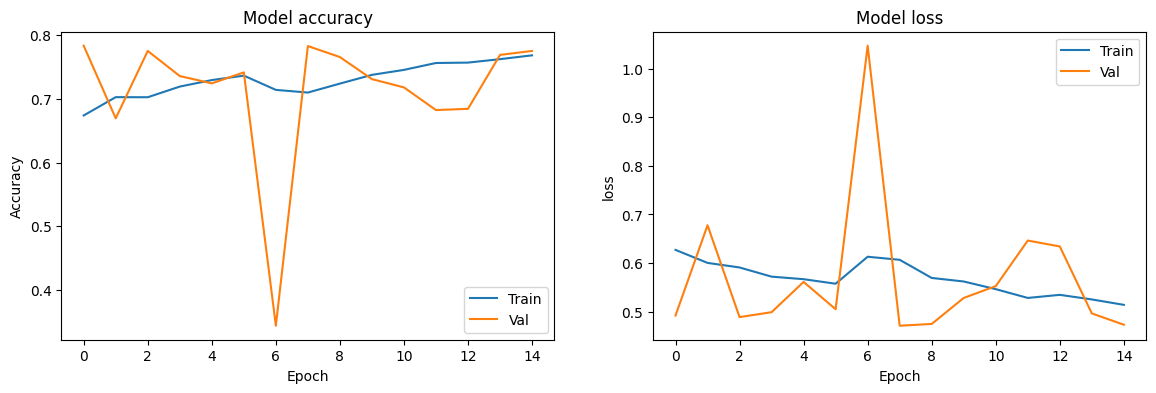

In [17]:
accuracy_loss_plot(history)

In [18]:
accr = model.evaluate(test_padded,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

82/82 [==============================] - 0s 3ms/step - loss: 0.5418 - accuracy: 0.7178
Test set
  Loss: 0.542
  Accuracy: 0.718


- Model 2: Using GloVe Embeddings

In [19]:
from tqdm import tqdm
from keras.layers import Dense,SpatialDropout1D
from nltk.tokenize import word_tokenize

"""Creates corpus from feature column, which is a pandas series"""
def create_corpus(df):
    corpus=[]
    for phrase in tqdm(df['Phrase']):
        words=[word.lower() for word in word_tokenize(phrase) if(word.isalpha()==1)]
        corpus.append(words)
    return corpus

In [20]:
"""Creates an embedding dictionary using GloVe"""
embedding_dict={}
with open('../datasets/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [21]:
"""Create padded sequences of equal lenght as input to LSTM"""
tokenizer_obj=Tokenizer()

def create_padded_inputs(corpus):
    MAX_LEN=20
    tokenizer_obj.fit_on_texts(corpus)
    sequences=tokenizer_obj.texts_to_sequences(corpus)

    phrase_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')
    return phrase_pad

In [22]:
corpus=create_corpus(df)
phrase_pad = create_padded_inputs(corpus)

word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

100%|██████████| 13004/13004 [00:00<00:00, 15439.86it/s]


Number of unique words: 4974


In [23]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 4974/4974 [00:00<00:00, 265392.04it/s]


In [24]:
model_embed = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=20,trainable=False),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])


opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

model_embed.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

In [25]:
model_embed.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 100)           497500    
                                                                 
 spatial_dropout1d (Spatial  (None, 20, 100)           0         
 Dropout1D)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 539805 (2.06 MB)
Trainable params: 42305 (165.25 KB)
Non-trainable params: 497500 (1.90 MB)
_________________________________________________________________


In [26]:
X_train, y_train, X_test, y_test = split_train_test(phrase_pad, df['Target'], 0.8)

In [27]:
history=model_embed.fit(X_train,y_train,batch_size=4,epochs=15,validation_split=0.2,verbose=2)

Epoch 1/15
2081/2081 - 23s - loss: 0.6715 - accuracy: 0.6640 - val_loss: 0.5741 - val_accuracy: 0.7756 - 23s/epoch - 11ms/step
Epoch 2/15
2081/2081 - 18s - loss: 0.5781 - accuracy: 0.6973 - val_loss: 0.4604 - val_accuracy: 0.8059 - 18s/epoch - 9ms/step
Epoch 3/15
2081/2081 - 18s - loss: 0.5277 - accuracy: 0.7471 - val_loss: 0.4651 - val_accuracy: 0.7660 - 18s/epoch - 9ms/step
Epoch 4/15
2081/2081 - 18s - loss: 0.5137 - accuracy: 0.7519 - val_loss: 0.4545 - val_accuracy: 0.7708 - 18s/epoch - 9ms/step
Epoch 5/15
2081/2081 - 18s - loss: 0.5067 - accuracy: 0.7571 - val_loss: 0.4533 - val_accuracy: 0.7641 - 18s/epoch - 9ms/step
Epoch 6/15
2081/2081 - 18s - loss: 0.5045 - accuracy: 0.7555 - val_loss: 0.4454 - val_accuracy: 0.7727 - 18s/epoch - 9ms/step
Epoch 7/15
2081/2081 - 18s - loss: 0.4981 - accuracy: 0.7590 - val_loss: 0.4556 - val_accuracy: 0.7660 - 18s/epoch - 9ms/step
Epoch 8/15
2081/2081 - 18s - loss: 0.4944 - accuracy: 0.7618 - val_loss: 0.4442 - val_accuracy: 0.7732 - 18s/epoch - 

### Model Evaluations

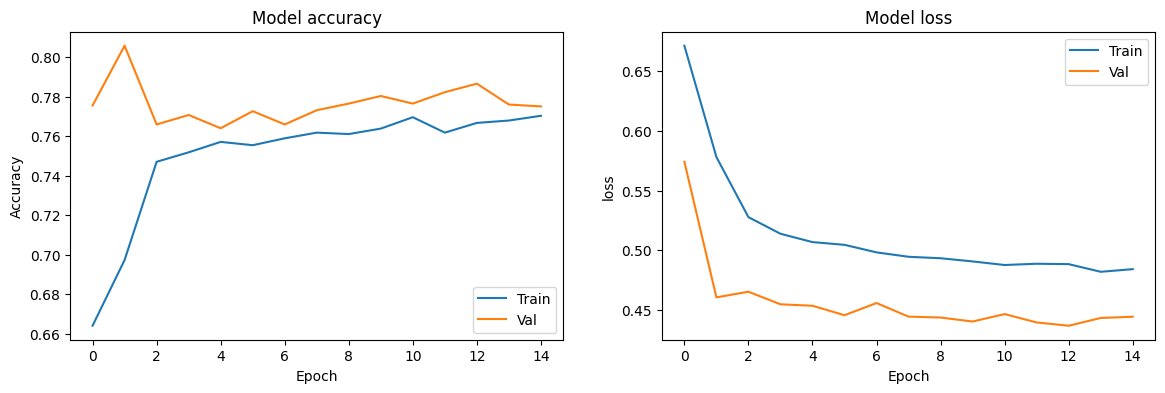

In [28]:
accuracy_loss_plot(history)

In [29]:
accr = model_embed.evaluate(X_test,y_test)
print('Test set\n  Loss for model embed: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

82/82 [==============================] - 0s 3ms/step - loss: 0.4935 - accuracy: 0.7432
Test set
  Loss for model embed: 0.493
  Accuracy: 0.743


82/82 [==============================] - 0s 2ms/step


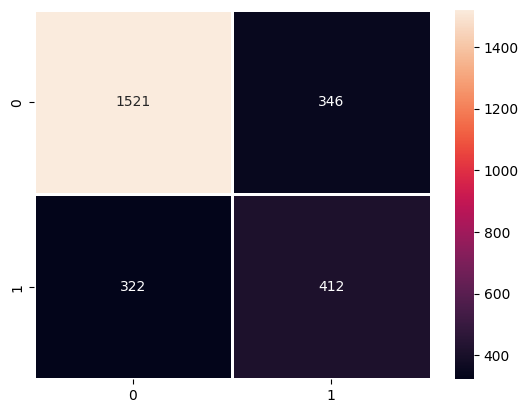

In [30]:
#evaluate
import seaborn as sns
from sklearn.metrics import confusion_matrix

#convert probabilistic output to binary
y_pred = (model_embed.predict(X_test) > 0.5).astype("int32")
#confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix, linewidths = 1, fmt= 'g', annot=True);

In [31]:
#precision, recall, AUC, ROC Curve
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
accuracy = accuracy_score(y_test, y_pred)
metric = list(precision_recall_fscore_support(y_test, y_pred, average='macro'))
print('Set Accuracy: \t', round(accuracy * 100, 2))
print('Set Precision: \t', round(metric[0], 2))
print('Set Recall: \t', round(metric[1], 2))
print('Set F score: \t', round(metric[2], 2))

Set Accuracy: 	 74.32
Set Precision: 	 0.68
Set Recall: 	 0.69
Set F score: 	 0.69


### Model Saving

In [32]:
model_embed.save('models/skillExtractor.h5')

/Users/koechian/anaconda3/envs/skillexplore/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
